In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 파라미터 정의
def param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0):
    beta = pump/b_freq_p
    rp = (1/4) * np.log((1 + beta) / (1 - beta))
    bs_freq = np.sqrt(1-beta**2)*b_freq_p + b_freq - b_freq_p
    a_freq_bs = a_freq - bs_freq
    noise = 2 * np.sinh(rp)**2 * b_loss
    Js = np.cosh(rp)*J0

    return beta, rp, bs_freq, a_freq_bs, noise, Js

def param_reproduce(kappa_ext, delta, J0, b_freq_p, pump):
    kappa = 1
    a_freq = delta
    b_freq = delta
    a_loss = kappa
    b_loss = kappa
    ex1 = kappa_ext
    ex2 = kappa_ext

    params_squeeze = param_squeezing(pump, b_freq_p, a_freq, b_freq, b_loss, J0)

    return a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, params_squeeze




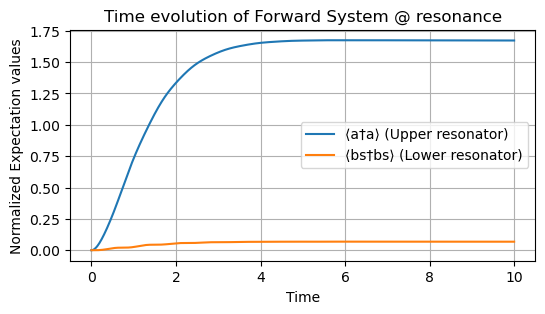

0.99 1.5922959196795805
0.8309158524882108 0.1345560496145238


In [16]:
a_freq, b_freq, a_loss, b_loss, ex1, ex2, J0, params_squeeze = param_reproduce(kappa_ext=0.99, delta=0, J0=0.99, b_freq_p=10.3, pump=10)
beta, rp, bs_freq, a_freq_bs, noise, Js = params_squeeze

# 초기 조건 (모두 0으로 시작한다고 가정)
# state: [Re(a), Im(a), Re(bs), Im(bs), Re(a_dagger_bs), Im(a_dagger_bs), a_dagger_a, bs_dagger_bs]
y0 = np.zeros(8)
AMP = 100
ab_loss = a_loss+b_loss
def forward_system(t, y):
    ain = AMP

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * Js * bs
    dbs = -(1j * bs_freq + b_loss) * bs - 1j * Js * a
    d_a_bs = (1j * a_freq_bs - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * Js * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = (1j * Js * ab_imag).real - 2 * b_loss * bs_dagger_bs + noise
    d_aa = -(1j * Js * ab_imag).real + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a).real - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa, d_bs_bs
    ]

# 시간 구간 및 풀이
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

sol = solve_ivp(forward_system, t_span, y0, t_eval=t_eval)

T12=1-np.sqrt(2 * ex1)*(sol.y[0][-1]*2)/AMP + 2*ex1*sol.y[6][-1]/AMP**2
T14=2 * ex2 * sol.y[7][-1] / AMP**2

# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Time evolution of Forward System @ resonance")
plt.legend()
plt.grid(True)
plt.savefig('figures/fore0.png')
plt.show()

print(J0, Js)
print(T12, T14)

0 0


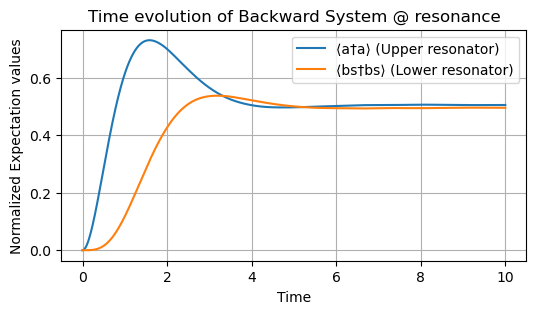

0.99 0.99
-0.00014170169239680064 0.9806142093366609


In [104]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 파라미터 정의
kappa = 1
kappa_ext = 0.99
delta = 0


J0 = 0.99
delbp = 10.3
pump = 10


beta = pump/delbp
rp = (1/4) * np.log((1 + beta) / (1 - beta))

a_freq = delta
bs_freq = delta
sab = a_freq - bs_freq
print(sab, delta)
a_loss = kappa
b_loss = kappa
ab_loss = a_loss+b_loss
Js = 1*J0
ex1 = kappa_ext
ex2 = kappa_ext
noise = 2 * np.sinh(rp)**2 * b_loss

# 초기 조건 (모두 0으로 시작한다고 가정)
# state: [Re(a), Im(a), Re(bs), Im(bs), Re(a_dagger_bs), Im(a_dagger_bs), a_dagger_a, bs_dagger_bs]
y0 = np.zeros(8)
AMP = 100
def backward_system(t, y):
    ain = AMP

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * Js * bs
    dbs = -(1j * bs_freq + b_loss) * bs - 1j * Js * a
    d_a_bs = (1j * sab - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * Js * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = (1j * Js * ab_imag).real - 2 * b_loss * bs_dagger_bs + noise
    d_aa = -(1j * Js * ab_imag).real + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a).real - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa, d_bs_bs
    ]

# 시간 구간 및 풀이
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

sol = solve_ivp(forward_system, t_span, y0, t_eval=t_eval)

T21=1-np.sqrt(2 * ex1)*(sol.y[0][-1]*2)/AMP + 2*ex1*sol.y[6][-1]/AMP**2
T23=2 * ex2 * sol.y[7][-1] / AMP**2

# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Time evolution of Backward System @ resonance")
plt.legend()
plt.grid(True)
plt.savefig('figures/back0.png')
plt.show()

print(J0, Js)
print(T21, T23)

0 2


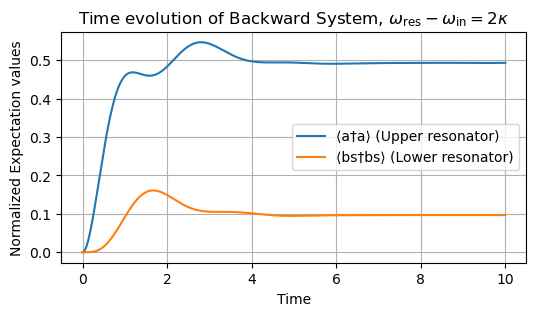

0.7969562846429271 0.19136899886243483


In [105]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 파라미터 정의
kappa = 1
kappa_ext = 0.99
delta = 2


J0 = 0.99
delbp = 10.3
pump = 10


beta = pump/delbp
rp = (1/4) * np.log((1 + beta) / (1 - beta))

a_freq = delta
bs_freq = delta
sab = a_freq - bs_freq
print(sab, delta)
a_loss = kappa
b_loss = kappa
ab_loss = a_loss+b_loss
Js = 1*J0
ex1 = kappa_ext
ex2 = kappa_ext
noise = 2 * np.sinh(rp)**2 * b_loss

# 초기 조건 (모두 0으로 시작한다고 가정)
# state: [Re(a), Im(a), Re(bs), Im(bs), Re(a_dagger_bs), Im(a_dagger_bs), a_dagger_a, bs_dagger_bs]
y0 = np.zeros(8)
AMP = 100
def backward_system(t, y):
    ain = AMP

    a = y[0] + 1j * y[1]
    bs = y[2] + 1j * y[3]
    a_dagger_bs = y[4] + 1j * y[5]
    a_dagger_a = y[6]
    bs_dagger_bs = y[7]

    # 시간 미분 계산
    da = -(1j * a_freq + a_loss) * a + np.sqrt(2 * ex1) * ain - 1j * Js * bs
    dbs = -(1j * bs_freq + b_loss) * bs - 1j * Js * a
    d_a_bs = (1j * sab - ab_loss) * a_dagger_bs + np.sqrt(2 * ex1) * np.conj(ain) * bs - 1j * Js * (a_dagger_a-bs_dagger_bs)
    ab_imag = (a_dagger_bs - np.conj(a_dagger_bs))
    d_bs_bs = (1j * Js * ab_imag).real - 2 * b_loss * bs_dagger_bs + noise
    d_aa = -(1j * Js * ab_imag).real + np.sqrt(2 * ex1) * (ain * np.conj(a) + np.conj(ain) * a).real - 2 * a_loss * a_dagger_a

    return [
        da.real, da.imag,
        dbs.real, dbs.imag,
        d_a_bs.real, d_a_bs.imag,
        d_aa, d_bs_bs
    ]

# 시간 구간 및 풀이
t_span = (0, 10)
t_eval = np.linspace(*t_span, 1000)

sol = solve_ivp(forward_system, t_span, y0, t_eval=t_eval)

T21=1-np.sqrt(2 * ex1)*(sol.y[0][-1]*2)/AMP + 2*ex1*sol.y[6][-1]/AMP**2
T23=2 * ex2 * sol.y[7][-1] / AMP**2

# 결과 시각화
plt.figure(figsize=(6, 3))
plt.plot(sol.t, sol.y[6]/AMP**2, label="⟨a†a⟩ (Upper resonator)")
plt.plot(sol.t, sol.y[7]/AMP**2, label="⟨bs†bs⟩ (Lower resonator)")
plt.xlabel("Time")
plt.ylabel("Normalized Expectation values")
plt.title("Time evolution of Backward System, $\omega_{\mathrm{res}} - \omega_{\mathrm{in}} = 2\kappa$")
plt.legend()
plt.grid(True)
plt.savefig('figures/back2.png')
plt.show()

print(T21, T23)